In [3]:
import os 
os.chdir('/home/xinglong/git_local/dynamax')

# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

import dynamax.structural_time_series.models.sts_model as sts

import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax import bijectors as tfb
from tensorflow_probability.substrates.jax import distributions as tfd
import time

## Synthetic Data

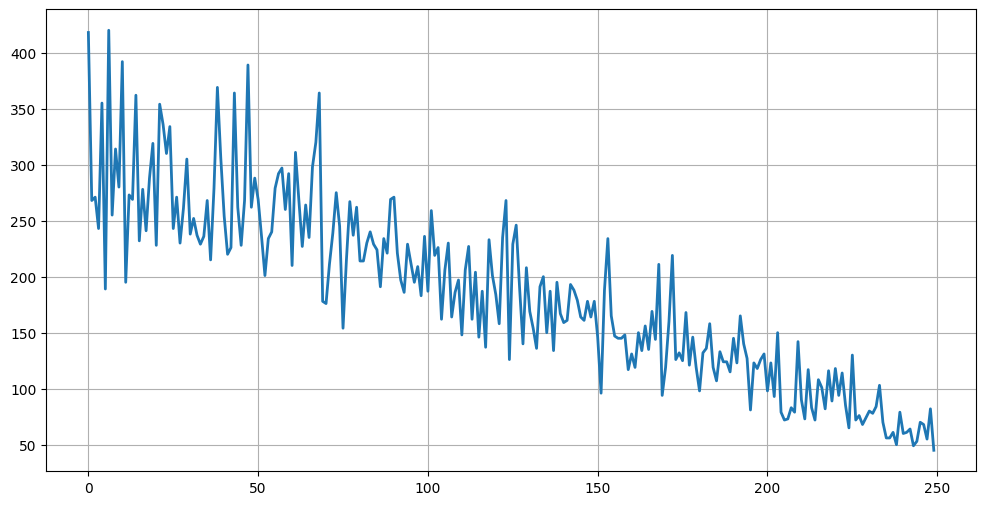

In [3]:
num_steps = 300
num_training_steps = 250
num_forecast_steps = num_steps - num_training_steps

np.random.seed(1)
counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_steps, 5, num=num_steps)), 0.2, size=num_steps))
counts = counts.astype(np.float32)
counts_training = counts[:num_training_steps]
plt.figure(figsize=(12, 6))
plt.plot(counts_training, lw=2)
plt.grid()

## Implementation in [TFP](https://www.tensorflow.org/probability/examples/STS_approximate_inference_for_models_with_non_Gaussian_observations)

Instead of operating on the observed time series, the model operates on the series of Poisson rate
parameters that govern the observations, which is transformed to real values Softplus transformation
$y = \log(1 + \exp(x))$.

To use approximate inference for a non-Gaussian observation model, it encodes the STS model as a
TFP JointDistribution. The random variables in this joint distribution are the parameters of the
STS model, the time series of latent Poisson rates, and the observed counts.

It uses HMC (specifically, NUTS) to sample from the joint posterior over model parameters and latent
rates. This will be significantly slower than fitting a standard STS model with HMC, since in addition
to the model's (relatively small number of) parameters it also has to infer the entire series of
Poisson rates.

In [4]:
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp
from tensorflow_probability.substrates.jax import bijectors as tfb
from tensorflow_probability.substrates.jax import distributions as tfd

# Build STS model with only LocalLinearTrend component.
def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
        observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend], observed_time_series=approximate_unconstrained_rates)

positive_bijector = tfb.Softplus()


In [5]:

approximate_unconstrained_rates = positive_bijector.inverse(
    counts_training + 0.01)

sts_model = build_model(approximate_unconstrained_rates)


In [6]:

# To use Poisson likelihood, it encodes the STS model as a TFP JointDistribution
def sts_with_poisson_likelihood_model():
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)
        
    unconstrained_rates = yield sts_model.make_state_space_model(
        num_training_steps, param_vals)
    rate = positive_bijector.forward(unconstrained_rates[..., 0])
    observed_counts = yield tfd.Poisson(rate, name='observed_counts')
    


In [7]:
model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)
pinned_model = model.experimental_pin(observed_counts=counts_training)
constraining_bijector = pinned_model.experimental_default_event_space_bijector()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:389: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:332: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/Library/F

In [8]:

# Inference with HMC
num_results = int(200)
num_burnin_steps = int(100)


In [9]:

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)


In [10]:

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)


In [11]:

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tfd.Normal(0.,1.,).sample(sample_shape=part_shape, seed=jr.PRNGKey(0))
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))


In [12]:

@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
        kernel=adaptive_sampler,
        current_state=initial_state,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        trace_fn=None,
        seed=jr.PRNGKey(0))


In [13]:

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print(f"Inference ran in {t1-t0:.3f}s")


: 

: 

In [ ]:

# Posterior Samples
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)


In [ ]:

plt.figure(figsize=(12, 6))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(counts_training, ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color='green', ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, num_training_steps), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, num_training_steps), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()
plt.grid()

# Forecasting
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_timesteps_forecast,
                             num_sampled_forecasts):
    
    unconstrained_rates_forecast_dist = tfp.sts.forecast(
        sts_model,
        observed_time_series=unconstrained_rate_samples,
        parameter_samples=posterior_params,
        num_steps_forecast=num_timesteps_forecast
        )
    rates_forecast_dist = tfd.TransformedDistribution(
        unconstrained_rates_forecast_dist, positive_bijector
        )
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates
    
forecast_samples, rate_samples = sample_forecasted_counts(
    sts_model, posterior_latent_rates=unconstrained_rate_samples,
    posterior_params=param_samples, num_timesteps_forecast=num_forecast_steps, num_sampled_forecasts=100)

forecast_samples = np.squeeze(forecast_samples)

def plot_forecast_helper(data, forecast_samples, CI=90):
    """Plot the observed time series alongside the forecast."""
    plt.figure(figsize=(12, 6))
    forecast_median = np.median(forecast_samples, axis=0)

    num_steps = len(data)
    num_forecast_steps = forecast_median.shape[-1]
    num_training_steps = num_steps - num_forecast_steps

    plt.plot(np.arange(num_steps), data, lw=2, linestyle='--', marker='o', label='Observed Data', alpha=0.7)

    forecast_steps = np.arange(num_training_steps, num_steps)

    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

    plt.plot(forecast_steps, forecast_median, lw=2, ls='--', marker='o', color='orange',
             label=str(CI) + '% Forecast Interval', alpha=0.7)
    plt.fill_between(forecast_steps, lower, upper, color='orange', alpha=0.2)

    plt.xlim([0, num_steps])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)),\
                 max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_forecast_steps) + ' Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.legend()
    plt.grid()
    
plot_forecast_helper(counts, forecast_samples, CI=80)

## Implementation via CMGF

In [6]:
counts = jnp.array(counts.reshape((num_steps, 1)))
counts_training = counts[:num_training_steps]
counts_predict = counts[-num_forecast_steps:]

### Build the STS model

In [7]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training)

### Model fitting

In [6]:
# Fit the model using HMC
obs_time_series = counts_training
key = jr.PRNGKey(0)
sample_size = 200

parameter_samples = model.fit_mle(key, sample_size, observed_time_series,
                                  inputs=None, warmup_steps=200, num_integration_steps=10)

  0%|          | 0/200 [00:00<?, ?it/s]

### Forecast

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")
/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax

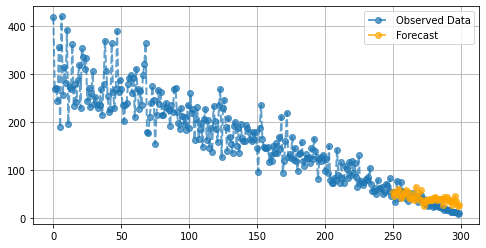

In [22]:
forecasts = model.forecast(jr.PRNGKey(0), observed_time_series, parameter_samples, num_timesteps_forecast)
forecast_means = jnp.median(jnp.squeeze(forecasts['means']), axis=0)
CI = 90
CI_interval = jnp.array([(100 - CI)/2, 100 - (100 - CI)/2])
lower, upper = jnp.percentile(jnp.squeeze(forecasts['means']), CI_interval, axis=0)
forecast_scale = jnp.std(jnp.squeeze(forecasts['means']), axis=0)

# Plot the prediction
time_steps = jnp.arange(num_timesteps)
time_steps_forecast = time_steps[-num_timesteps_forecast:]

fig = plt.figure(figsize=(8, 4))
plt.plot(time_steps, observed_counts, lw=2, linestyle='--', marker='o',
         alpha=0.7, label='Observed Data')
plt.plot(time_steps_forecast, forecast_means, lw=2, linestyle='--', marker='o',
         color='orange', alpha=0.7, label='Forecast')
plt.fill_between(time_steps_forecast, lower, upper, color='orange', alpha=0.3)
# plt.fill_between(time_steps_forecast, forecast_means-2*forecast_scale, forecast_means+2*forecast_scale, color='orange', alpha=0.3)
plt.grid()
plt.legend()